In [1]:
import torch
import time
import matplotlib.pyplot as plt


# Define the orthogonalization function
@torch.compile(dynamic=True)
def orthogonalize_matrix(
    G: torch.Tensor, ns_iters: int, tuned_ns_consts: bool, epsilon: float
):
    """
    Orthonormalize a 2D matrix G using either a QR decomposition (if ns_iters == -1)
    or Newton-Schulz iterations (if ns_iters >= 1).
    """
    if ns_iters == -1:
        # Use QR decomposition
        Q, R = torch.linalg.qr(G)
        return Q

    # Otherwise, use the Newton-Schulz approach.
    if tuned_ns_consts:
        # Tuned constants
        a, b, c = 3.4445, -4.7750, 2.0315
    else:
        # "Vanilla" constants
        a, b, c = 2.0, -1.5, 0.5

    # Normalize G so it doesn't blow up in iteration
    X = G / (G.norm() + epsilon)
    transposed = False

    # If G has more rows than columns, transpose it
    if X.size(0) > X.size(1):
        X = X.T
        transposed = True

    for _ in range(ns_iters):
        A = X @ X.T
        B = b * A + c * (A @ A)
        X = a * X + B @ X

    if transposed:
        X = X.T

    return X


# Function to measure elapsed time on CPU or GPU
def measure_time(func, device, *args, **kwargs):
    torch.cuda.empty_cache()  # Clear GPU memory before timing
    torch.cuda.synchronize()  # Ensure all operations are completed before timing

    start_mem = torch.cuda.memory_allocated() if device == "cuda" else None
    start_time = time.perf_counter()  # Start high-precision timer

    result = func(*args, **kwargs)

    torch.cuda.synchronize()  # Ensure operations finish before stopping time
    elapsed_time = time.perf_counter() - start_time  # Compute elapsed time
    end_mem = torch.cuda.memory_allocated() if device == "cuda" else None

    memory_used = (
        (end_mem - start_mem) / (1024**2) if device == "cuda" else None
    )  # Convert to MB
    return result, elapsed_time, memory_used


# Set random seed for reproducibility and create a random matrix G

In [21]:
G_cpu = torch.randn(10000, 10000)
G_gpu = G_cpu.to("cuda")  # Move to GPU

# Compare QR decomposition and Newton-Schulz on CPU
Q_qr_cpu, time_qr_cpu, _ = measure_time(
    orthogonalize_matrix, "cpu", G_cpu, ns_iters=-1, tuned_ns_consts=False, epsilon=1e-8
)
Q_ns_cpu, time_ns_cpu, _ = measure_time(
    orthogonalize_matrix, "cpu", G_cpu, ns_iters=5, tuned_ns_consts=True, epsilon=1e-8
)
Q_ns2_cpu, time_ns2_cpu, _ = measure_time(
    orthogonalize_matrix, "cpu", G_cpu, ns_iters=10, tuned_ns_consts=True, epsilon=1e-8
)

# Compare QR decomposition and Newton-Schulz on GPU
Q_qr_gpu, time_qr_gpu, mem_qr = measure_time(
    orthogonalize_matrix,
    "cuda",
    G_gpu,
    ns_iters=-1,
    tuned_ns_consts=False,
    epsilon=1e-8,
)
Q_ns_gpu, time_ns_gpu, mem_ns = measure_time(
    orthogonalize_matrix, "cuda", G_gpu, ns_iters=5, tuned_ns_consts=True, epsilon=1e-8
)
Q_ns2_gpu, time_ns2_gpu, mem_ns2 = measure_time(
    orthogonalize_matrix, "cuda", G_gpu, ns_iters=10, tuned_ns_consts=True, epsilon=1e-8
)

# Print CPU and GPU timing results
print("\n==== CPU Performance ====")
print(f"QR decomposition time: {time_qr_cpu:.6f} seconds")
print(f"Newton-Schulz (5 iterations) time: {time_ns_cpu:.6f} seconds")
print(f"Newton-Schulz (10 iterations) time: {time_ns2_cpu:.6f} seconds")

print("\n==== GPU Performance ====")
print(f"QR decomposition time: {time_qr_gpu:.6f} seconds, Memory used: {mem_qr:.2f} MB")
print(
    f"Newton-Schulz (5 iterations) time: {time_ns_gpu:.6f} seconds, Memory used: {mem_ns:.2f} MB"
)
print(
    f"Newton-Schulz (10 iterations) time: {time_ns2_gpu:.6f} seconds, Memory used: {mem_ns2:.2f} MB"
)

# Compare speedup factors
print("\n==== Speedup (CPU vs. GPU) ====")
print(f"QR decomposition speedup: {time_qr_cpu / time_qr_gpu:.2f}x")
print(f"Newton-Schulz (5 iterations) speedup: {time_ns_cpu / time_ns_gpu:.2f}x")
print(f"Newton-Schulz (10 iterations) speedup: {time_ns2_cpu / time_ns2_gpu:.2f}x")


==== CPU Performance ====
QR decomposition time: 1.843549 seconds
Newton-Schulz (5 iterations) time: 7.259573 seconds
Newton-Schulz (10 iterations) time: 15.025703 seconds

==== GPU Performance ====
QR decomposition time: 0.205344 seconds, Memory used: 382.00 MB
Newton-Schulz (5 iterations) time: 0.732142 seconds, Memory used: 382.00 MB
Newton-Schulz (10 iterations) time: 1.536404 seconds, Memory used: 382.00 MB

==== Speedup (CPU vs. GPU) ====
QR decomposition speedup: 8.98x
Newton-Schulz (5 iterations) speedup: 9.92x
Newton-Schulz (10 iterations) speedup: 9.78x


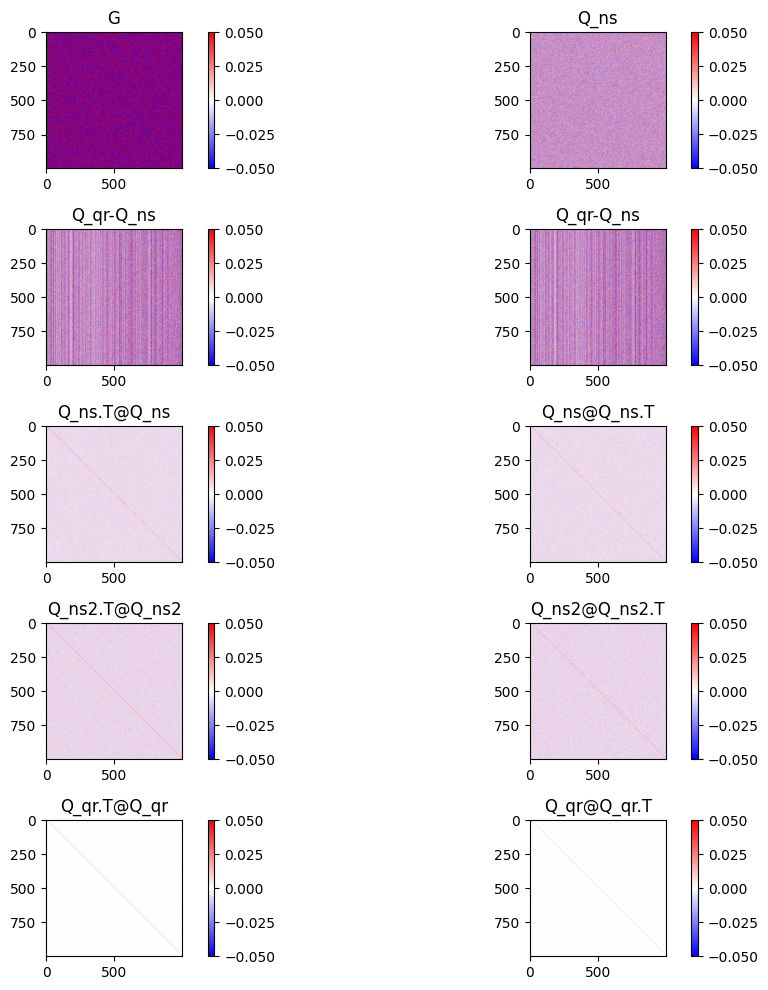

In [20]:
import matplotlib.pyplot as plt

Q_qr = Q_qr_gpu.cpu()
Q_ns = Q_ns_gpu.cpu()
Q_ns2 = Q_ns2_gpu.cpu()


def plot_matrix(ax, matrix, title):
    matrix_np = matrix.numpy()
    # vmax = np.percentile(np.abs(matrix_np), 100)  # Clip extreme values for better contrast
    im = ax.imshow(matrix_np, cmap="bwr", vmin=-0.05, vmax=0.05)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


# Create subplots to visualize the matrices and their difference
fig, axes = plt.subplots(5, 2, figsize=(12, 10))


plot_matrix(axes[0, 0], G_cpu, "G")
plot_matrix(axes[0, 1], Q_ns, "Q_ns")
plot_matrix(axes[1, 0], Q_qr - Q_ns, "Q_qr-Q_ns")
plot_matrix(axes[1, 1], Q_qr - Q_ns, "Q_qr-Q_ns")
plot_matrix(axes[2, 0], Q_ns.T @ Q_ns, "Q_ns.T@Q_ns")
plot_matrix(axes[2, 1], Q_ns @ Q_ns.T, "Q_ns@Q_ns.T")
plot_matrix(axes[3, 0], Q_ns2.T @ Q_ns2, "Q_ns2.T@Q_ns2")
plot_matrix(axes[3, 1], Q_ns2 @ Q_ns2.T, "Q_ns2@Q_ns2.T")
plot_matrix(axes[4, 0], Q_qr.T @ Q_qr, "Q_qr.T@Q_qr")
plot_matrix(axes[4, 1], Q_qr @ Q_qr.T, "Q_qr@Q_qr.T")

plt.tight_layout()
plt.show()

In [17]:
import torch

A = torch.randn(5, 5)
A = A + A.T

In [18]:
U, S, Vh = torch.linalg.svd(A, full_matrices=False)
torch.dist(A, U @ torch.diag(S) @ Vh)

tensor(5.5145e-06)

In [19]:
torch.dist(A, U @ torch.diag(S) @ Vh.T)

tensor(8.9219)